#|| **Future Passenger and Trip Predictions** ||

## Objective
Our project aims to develop and compare two different models, a GRU (Gated Recurrent Unit) model, and a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model, to forecast future passenger and trip numbers for public transport in Riyadh. By leveraging historical data on the number of passengers and trips within the city, both models will be trained to provide accurate demand forecasts. These predictions will enable transportation authorities to optimize resource planning, including trip scheduling and resource allocation, ensuring efficient and sustainable services for citizens and residents.




## Task 1: Problem Identification and Data Gathering

## Problem Identification
Public transport systems in Riyadh face challenges in accurately predicting future demand, leading to an imbalance between supply and demand. This imbalance may result in issues such as overcrowding during peak hours or insufficient availability of transport in certain areas, ultimately diminishing service quality and negatively impacting user satisfaction.


## Data Sources
Data was collected from the Saudi Public Transport Authority through the open data platform, which includes the total number of passengers and public transport trips within cities by year, region, city and station. [Dataset URL](https://open.data.gov.sa/ar/datasets/view/5548a5ed-46b8-4ea5-938d-372958177f30/resources)

## Model Comparison
we implemented two different forecasting models: the GRU model, known for its ability to capture complex patterns and long-term dependencies in sequential data, and the SARIMA model, which excels in modeling seasonal and trend components. By comparing the performance of these models using various evaluation metrics, we determined which model best fits the data and provides the most accurate forecasts for public transport demand in Riyadh.

# Task 2: Exploratory Data Analysis (EDA)

---



2.1  Load the necessary libraries

In [ ]:
%pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

# Model 1 : GRU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Model 2 : SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

2.2 Load the dataset

In [ ]:
dataset = pd.read_excel('/content/The total number of passengers and public transport trips in Riyadh.xlsx')

2.3 Check the Columns and Data Types

In [ ]:
# inspect the dataset
dataset.head()

,Year,Month,Region,Path,Line Name,Number of Trips,Number of Passengers
0,2018,January,Riyadh,7,University Hospital,1554,36809.0
1,2018,January,Riyadh,8,Dala School,4224,136039.0
2,2018,January,Riyadh,9,North Markets,264,7639.0
3,2018,January,Riyadh,10,Al Rawdah District,1110,7366.0
4,2018,January,Riyadh,16,Jeddah Bridge,1110,8665.0


In [ ]:
# Dataset types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  378 non-null    int64  
 1   Month                 378 non-null    object 
 2   Region                378 non-null    object 
 3   Path                  378 non-null    int64  
 4   Line Name             378 non-null    object 
 5   Number of Trips       378 non-null    int64  
 6   Number of Passengers  378 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 20.8+ KB


2.4 Data Cleaning

   *   Handling Missing Values
---






In [ ]:
# Check if there missing values
dataset.isnull().sum()

,0
Year,0
Month,0
Region,0
Path,0
Line Name,0
Number of Trips,0
Number of Passengers,0


In the dataset there is no null values

*   Remove any duplicate rows.

---




In [ ]:
dataset.duplicated().sum()

0

In the dataset there is no duplicate

2.5 Descriptive Statistics

In [ ]:
dataset.describe()

,Year,Path,Number of Trips,Number of Passengers
count,378.000000,378.000000,378.000000,378.000000
mean,2020.142857,11.166667,5638.735450,82225.761716
std,1.522846,3.896029,2266.779841,45296.993806
min,2018.000000,7.000000,0.000000,0.000000
25%,2019.000000,8.000000,3875.000000,53823.500000
50%,2020.000000,9.500000,6480.500000,76993.500000
75%,2021.000000,16.000000,7205.250000,100288.000000
max,2023.000000,17.000000,13863.000000,223552.000000


# Notes:

*   The dataset consists of **378 entries** spanning from **2018 to 2023**,

*   The minimum value for the `number of trips` is **0**, which could be due to the impact of the COVID-19 pandemic during 2020 and beyond, resulting in periods with no trips.




*   Count of Unique Values
---





In [ ]:
# Count of Unique Values for `Path` column
dataset['Line Name'].value_counts()

,count
Line Name,
University Hospital,63
Dala School,63
North Markets,63
Al Rawdah District,63
Jeddah Bridge,63
Industrial City,63


2.6 Data Visualization



*   Box plot to identify outliers

---






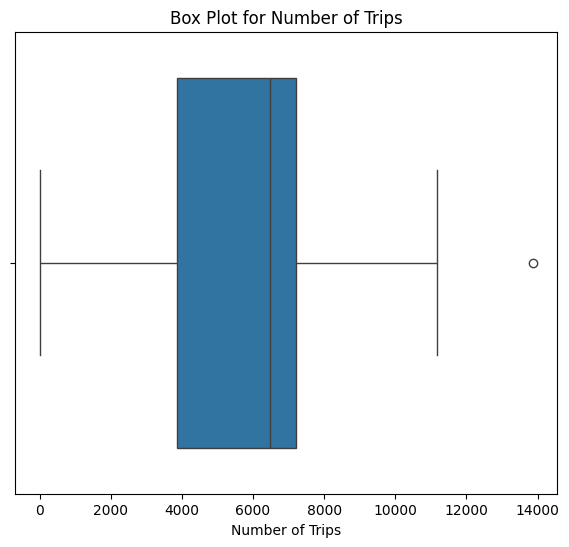

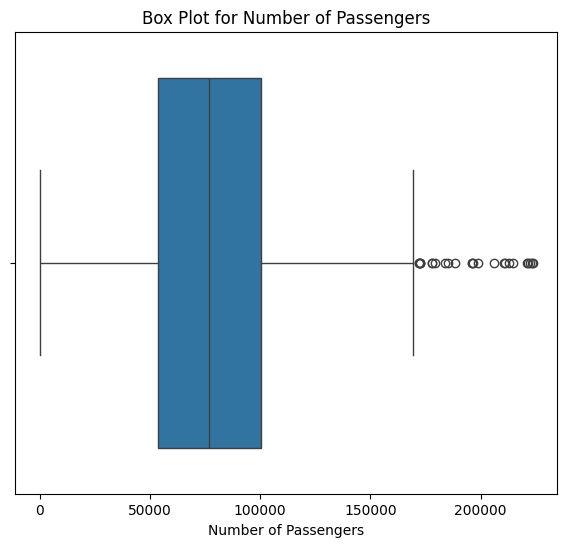

In [ ]:
numerical_columns = ['Number of Trips', 'Number of Passengers']

for column in numerical_columns:
    plt.figure(figsize=(7, 6))
    sns.boxplot(x=dataset[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

There are outliers in the `Number of Passengers` column.

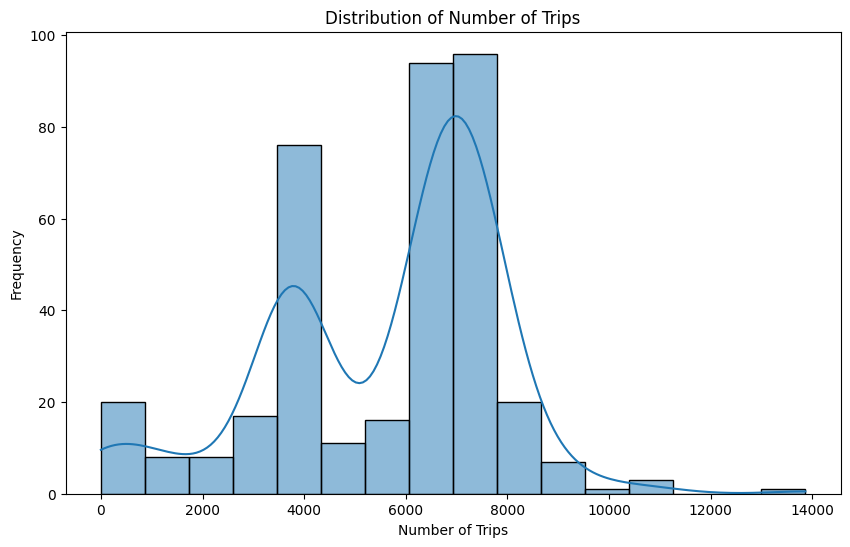

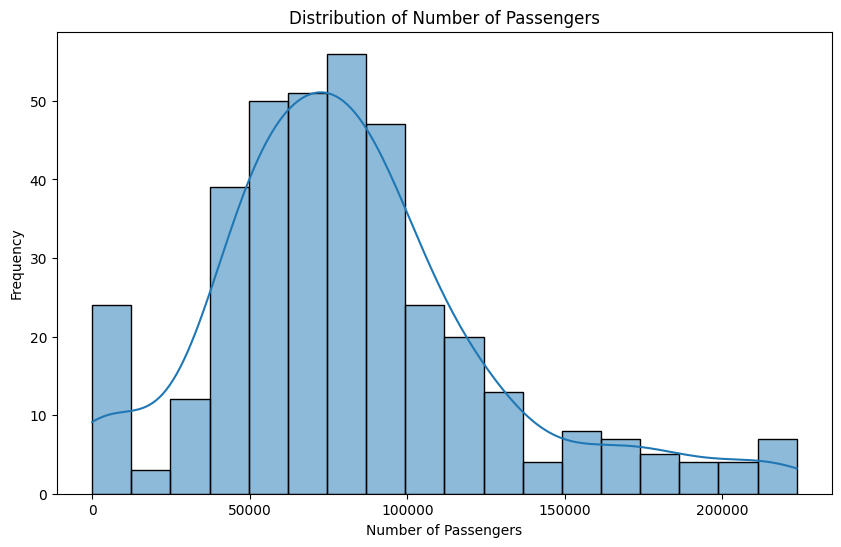

In [ ]:
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(dataset[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()



*   This distribution in `Number of Trips`& `Number of Passengers` is **not normal** and is skewed to the right.

* Based on this, we need to scaling the data could improve the performance of the models





2.7 Data preprocessing

*   Drop Unnecessary columns
---





In [ ]:
dataset.drop(columns=['Line Name', 'Region '], inplace=True)

*   Handel the outliers

---





In [ ]:
# Function to remove outliers using IQR
def remove_outliers(column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset_filtered = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)]
    return dataset_filtered

for column in numerical_columns:
    dataset = remove_outliers(column)

*   `map` function to  "Month" column

---





In [ ]:
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

dataset['Month'] = dataset['Month'].map(month_mapping)

In [ ]:
print(dataset)

     Year   Month  Path  Number of Trips  Number of Passengers
0     2018      1     7             1554               36809.0
1     2018      1     8             4224              136039.0
2     2018      1     9              264                7639.0
3     2018      1    10             1110                7366.0
4     2018      1    16             1110                8665.0
..     ...    ...   ...              ...                   ...
373   2023      3     8             3609               52190.0
374   2023      3     9             3871               93160.0
375   2023      3    10             2250               36539.0
376   2023      3    16             3708               59038.0
377   2023      3    17             1788               56480.0

[353 rows x 5 columns]


*   MinMax Scaling

---






In [ ]:
columns_to_scale = ['Number of Trips', 'Number of Passengers']

scaler = MinMaxScaler()

dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])

#Check the scaled data
print(dataset.head())


   Year   Month  Path  Number of Trips  Number of Passengers
0   2018      1     7         0.139247              0.217691
1   2018      1     8         0.378495              0.804546
2   2018      1     9         0.023656              0.045178
3   2018      1    10         0.099462              0.043563
4   2018      1    16         0.099462              0.051246


*   Exploring Seasonal, Occasional, and Cyclic Trends

---





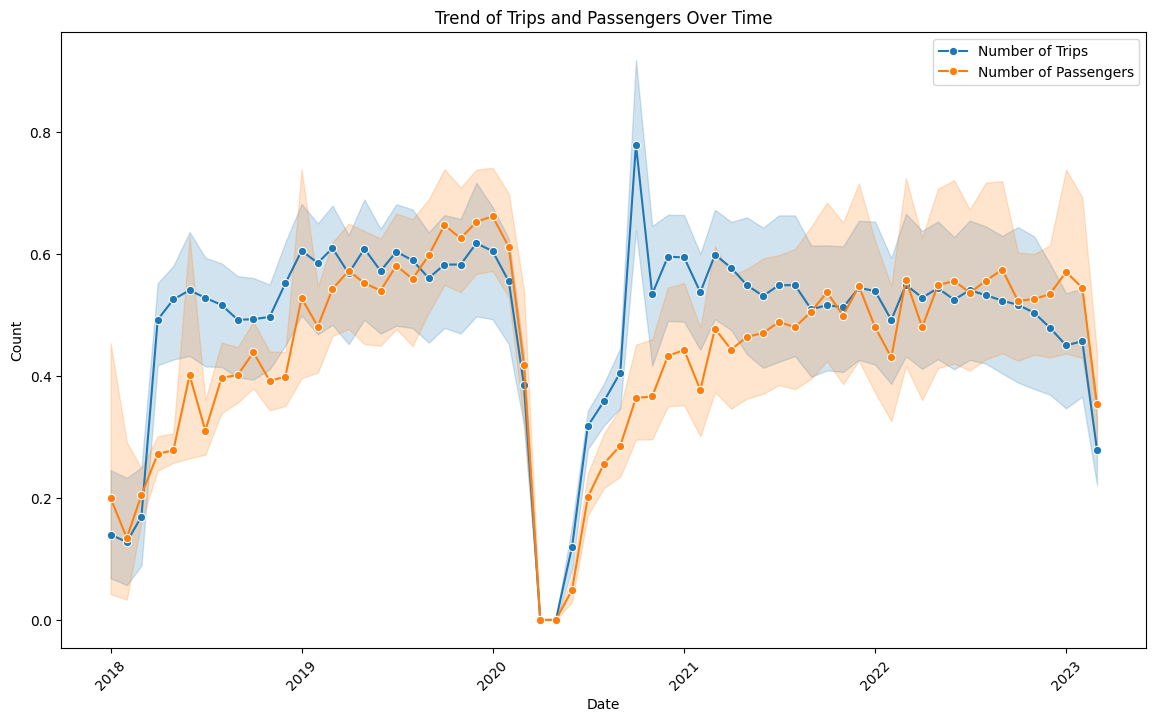

In [ ]:
# Convert Month to a datetime format
dataset['Date'] = dataset['Year '].astype(str) + '-' + dataset['Month'].astype(str)
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y-%m')

 #Plotting trends over time
plt.figure(figsize=(14, 8))
sns.lineplot(x='Date', y='Number of Trips', data=dataset, marker='o', label='Number of Trips')
sns.lineplot(x='Date', y='Number of Passengers', data=dataset, marker='o', label='Number of Passengers')
plt.title('Trend of Trips and Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
df_agg = dataset.groupby(['Year ', 'Month']).agg({'Number of Passengers': 'sum',
                                                 'Number of Trips': 'sum'}).reset_index()
# Rename the columns
df_agg.rename(columns={'Year ': 'Year', 'Month ': 'Month'}, inplace=True)

# Convert Year and Month to a datetime index
df_agg['Date'] = pd.to_datetime(df_agg[['Year', 'Month']].assign(Day=1))
df_agg.set_index('Date', inplace=True)

df_agg.head()

,Year,Month,Number of Passengers,Number of Trips
Date,,,,
2018-01-01,2018,1,1.196084,0.838172
2018-02-01,2018,2,0.806610,0.766667
2018-03-01,2018,3,1.024648,0.847312
2018-04-01,2018,4,1.360108,2.459767
2018-05-01,2018,5,1.390146,2.626075


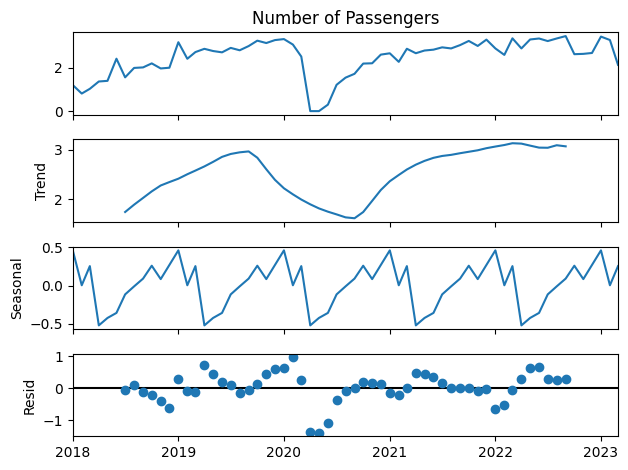

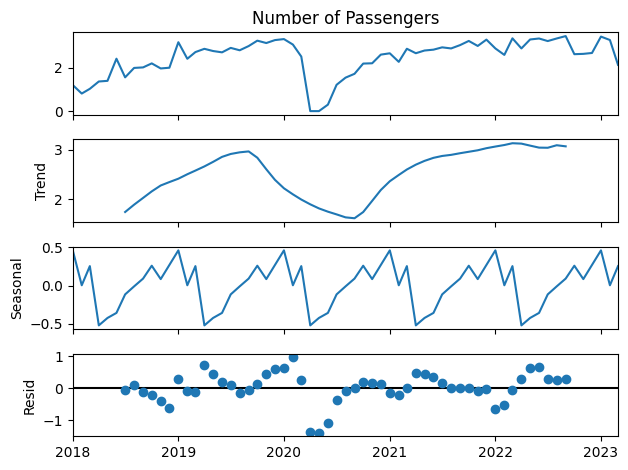

In [ ]:
# Perform ETS decomposition using an additive model
result = seasonal_decompose(df_agg['Number of Passengers'], model='additive')

# Plot the decomposition
result.plot()


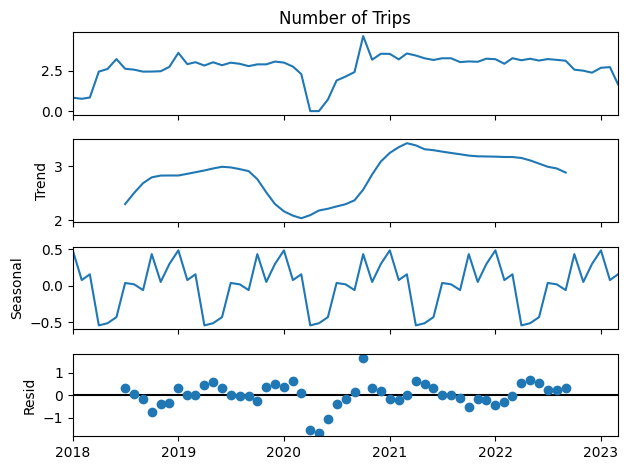

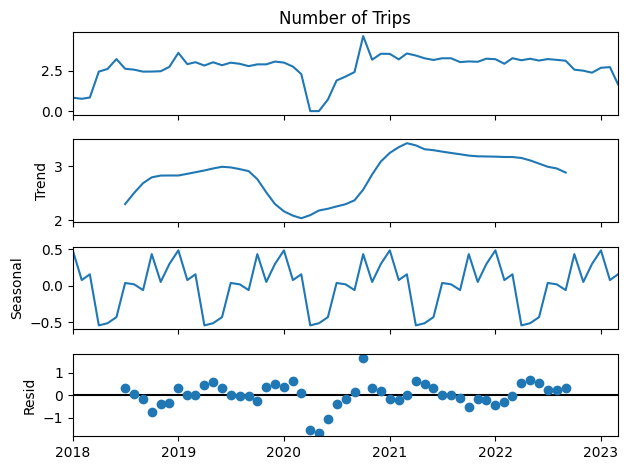

In [ ]:
result_trips = seasonal_decompose(df_agg['Number of Trips'], model='additive')

result_trips.plot()

# Task 3: Model Development and Training

---



# GRU model

3.1 Prepare the data

In [ ]:
scaler = MinMaxScaler()
df_agg[['Number of Passengers', 'Number of Trips']] = scaler.fit_transform(df_agg[['Number of Passengers', 'Number of Trips']])

In [ ]:
def create_sequences_multivariate(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps = 12
X, y = create_sequences_multivariate(df_agg[['Number of Passengers', 'Number of Trips']].values, n_steps)

3.2 Split the data

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3.3 Build the GRU Model

In [ ]:
# Building GRU model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(n_steps, 2)))  # 2 features
model.add(GRU(50))
model.add(Dense(2))  # Output layer with 2 neurons, one for each feature
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3.5 Train the Model

In [ ]:
# Reshape X for training
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 2))

In [ ]:
history = model.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_test_reshaped, y_test))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 697ms/step - loss: 0.3394 - val_loss: 0.1913
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1853 - val_loss: 0.0729
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0821 - val_loss: 0.0245
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0394 - val_loss: 0.0396
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0609 - val_loss: 0.0575
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0782 - val_loss: 0.0504
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0687 - val_loss: 0.0330
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0468 - val_loss: 0.0211
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0413 - val_loss: 0.0191
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0366 - val_loss: 0.0230
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0430 - val_loss: 0.0271
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0440 - val_l

3.6 Evaluate the Model

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0062
Test Loss: 0.006237423047423363


3.6 Make Predictions

In [ ]:
# Make predictions
y_pred = model.predict(X_test_reshaped)

# Inverse the scaling to get the predictions back to the original scale
y_pred_original = scaler.inverse_transform(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


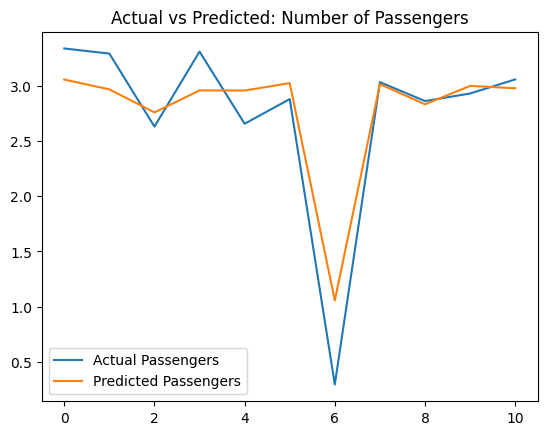

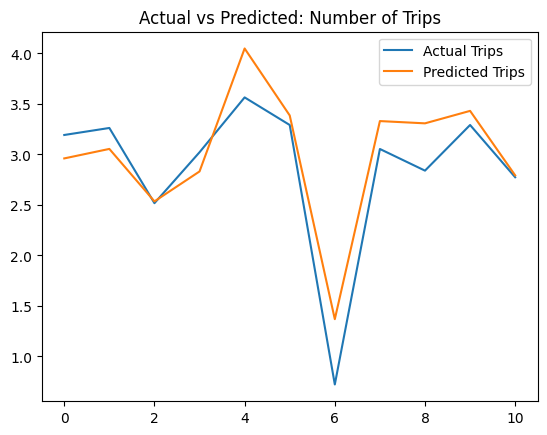

In [ ]:
# Inverse transform the actual values
y_test_original = scaler.inverse_transform(y_test)

# Plot the actual vs predicted values for the Number of Passengers feature
plt.plot(y_test_original[:, 0], label='Actual Passengers')
plt.plot(y_pred_original[:, 0], label='Predicted Passengers')
plt.legend()
plt.title('Actual vs Predicted: Number of Passengers')
plt.show()

# Plot the actual vs predicted values for the Number of Trips feature
plt.plot(y_test_original[:, 1], label='Actual Trips')
plt.plot(y_pred_original[:, 1], label='Predicted Trips')
plt.legend()
plt.title('Actual vs Predicted: Number of Trips')
plt.show()


# Task 4: Model Evaluation and Selection

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate evaluation metrics for the Number of Passengers feature
mse_passengers = mean_squared_error(y_test[:, 0], y_pred[:, 0])
rmse_passengers = mean_squared_error(y_test[:, 0], y_pred[:, 0], squared=False)
mae_passengers = mean_absolute_error(y_test[:, 0], y_pred[:, 0])

# Calculate evaluation metrics for the Number of Trips feature
mse_trips = mean_squared_error(y_test[:, 1], y_pred[:, 1])
rmse_trips = mean_squared_error(y_test[:, 1], y_pred[:, 1], squared=False)
mae_trips = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

# Print the metrics for Number of Passengers
print(f"Mean Squared Error (MSE) - Passengers: {mse_passengers}")
print(f"Root Mean Squared Error (RMSE) - Passengers: {rmse_passengers}")
print(f"Mean Absolute Error (MAE) - Passengers: {mae_passengers}")
print('\n')
# Print the metrics for Number of Trips
print(f"Mean Squared Error (MSE) - Trips: {mse_trips}")
print(f"Root Mean Squared Error (RMSE) - Trips: {rmse_trips}")
print(f"Mean Absolute Error (MAE) - Trips: {mae_trips}")


Mean Squared Error (MSE) - Passengers: 0.007849607324053865
Root Mean Squared Error (RMSE) - Passengers: 0.08859800970706884
Mean Absolute Error (MAE) - Passengers: 0.0655912579375626


Mean Squared Error (MSE) - Trips: 0.004625238724685016
Root Mean Squared Error (RMSE) - Trips: 0.06800910765982021
Mean Absolute Error (MAE) - Trips: 0.05400828924248218




---



# Task 3: Model Development and Training

---

# SARIMA model

3.1 Check for Stationarity

In [ ]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

adf_test(df_agg['Number of Trips'])
adf_test(df_agg['Number of Passengers'])


ADF Statistic: -3.324619104049068
p-value: 0.013813231217716658
Critial Values:
   1%, -3.540522678829176
Critial Values:
   5%, -2.9094272025108254
Critial Values:
   10%, -2.5923136524453696
ADF Statistic: -2.8074682570906804
p-value: 0.05721487415276131
Critial Values:
   1%, -3.540522678829176
Critial Values:
   5%, -2.9094272025108254
Critial Values:
   10%, -2.5923136524453696


3.2 Fit the SARIMA Model

In [ ]:
# The SARIMA model for Number of Trips
sarima_trips = SARIMAX(df_agg['Number of Trips'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
sarima_trips_fit = sarima_trips.fit(disp=False)
print(sarima_trips_fit.summary())

# The SARIMA model for Number of Passengers
sarima_passengers = SARIMAX(df_agg['Number of Passengers'],
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 12))
sarima_passengers_fit = sarima_passengers.fit(disp=False)
print(sarima_passengers_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible sta

                                     SARIMAX Results                                      
Dep. Variable:                    Number of Trips   No. Observations:                   63
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  20.043
Date:                            Sun, 25 Aug 2024   AIC                            -30.086
Time:                                    16:33:41   BIC                            -20.526
Sample:                                01-01-2018   HQIC                           -26.445
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1069      5.287     -0.020      0.984     -10.469      10.255
ma.L1          0.0642      5.261   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:               Number of Passengers   No. Observations:                   63
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  13.500
Date:                            Sun, 25 Aug 2024   AIC                            -17.000
Time:                                    16:33:43   BIC                             -7.440
Sample:                                01-01-2018   HQIC                           -13.360
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3648      8.116     -0.045      0.964     -16.271      15.541
ma.L1          0.3417      8.268   

3.4 Forecasting

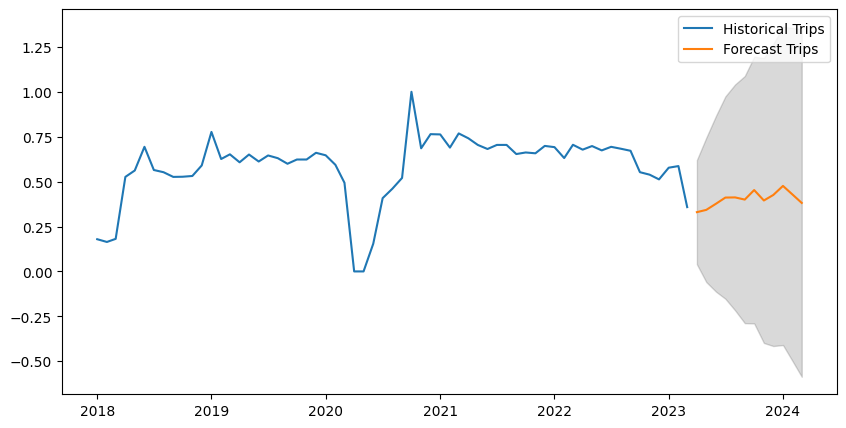

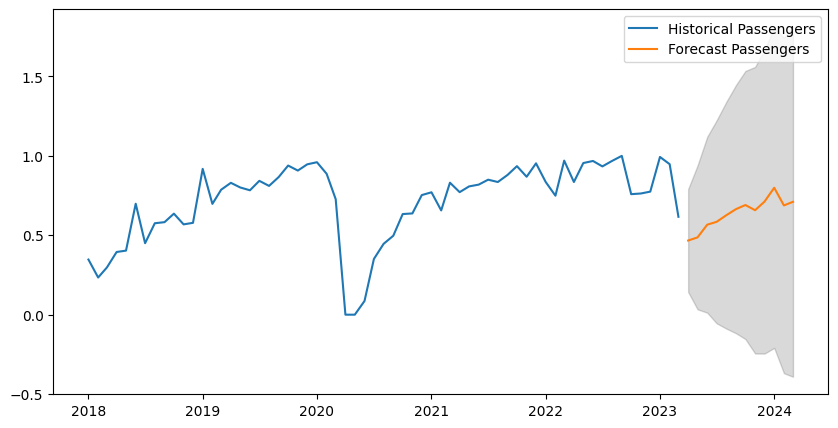

In [ ]:
forecast_trips = sarima_trips_fit.get_forecast(steps=12)
forecast_trips_ci = forecast_trips.conf_int()

forecast_passengers = sarima_passengers_fit.get_forecast(steps=12)
forecast_passengers_ci = forecast_passengers.conf_int()

# Plotting the forecast
plt.figure(figsize=(10, 5))
plt.plot(df_agg.index, df_agg['Number of Trips'], label='Historical Trips')
plt.plot(forecast_trips.predicted_mean.index, forecast_trips.predicted_mean, label='Forecast Trips')
plt.fill_between(forecast_trips_ci.index,
                 forecast_trips_ci.iloc[:, 0],
                 forecast_trips_ci.iloc[:, 1], color='k', alpha=.15)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_agg.index, df_agg['Number of Passengers'], label='Historical Passengers')
plt.plot(forecast_passengers.predicted_mean.index, forecast_passengers.predicted_mean, label='Forecast Passengers')
plt.fill_between(forecast_passengers_ci.index,
                 forecast_passengers_ci.iloc[:, 0],
                 forecast_passengers_ci.iloc[:, 1], color='k', alpha=.15)
plt.legend()
plt.show()


# Task 4: Model Evaluation and Selection

In [ ]:
from sklearn.metrics import mean_squared_error

mse_trips = mean_squared_error(df_agg['Number of Trips'], sarima_trips_fit.fittedvalues)
mse_passengers = mean_squared_error(df_agg['Number of Passengers'], sarima_passengers_fit.fittedvalues)

print(f'Mean Squared Error for Trips: {mse_trips}')
print(f'Mean Squared Error for Passengers: {mse_passengers}')

Mean Squared Error for Trips: 0.024608570836612245
Mean Squared Error for Passengers: 0.032680272179147735
